# Global Heat Budget Closure
*Contributors*: [Jan-Erik Tesdal](https://github.com/jetesdal), [Ryan Abernathey](https://github.com/rabernat), [Ian Fenty](https://github.com/ifenty), and [Andrew Delman](https://github.com/andrewdelman)

Updated 2024-10-17

A major part of this tutorial is based on "*A Note on Practical Evaluation of Budgets in ECCO Version 4 Release 3"* by Christopher G. Piecuch (https://ecco.jpl.nasa.gov/drive/files/Version4/Release3/doc/v4r3_budgets_howto.pdf). Calculation steps and Python code presented here are converted from the MATLAB code presented in the above reference.

## Objectives

Evaluating and closing the heat budget over the global ocean. 

## Introduction

The ocean heat content (OHC) variability is described here with potential temperature ($\theta$) which is given by the ECCOv4 diagnostic output `THETA`. The budget equation describing the change in $\theta$ is evaluated in general as

$$
\frac{\partial \theta}{\partial t} = -\nabla \cdot (\theta \mathbf{u})-\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}+{F}_\textrm{forc}^{\theta}
$$

The heat budget includes the change in temperature over time ($\frac{\partial \theta}{\partial t}$), the convergence of heat advection ($-\nabla \cdot (\theta \mathbf{u})$) and heat diffusion ($-\nabla\cdot\mathbf{F}_\textrm{diff}$), plus downward heat flux from the atmosphere (${F}_\textrm{forc}$). Note that in our definition ${F}_\textrm{forc}$ contains both latent and sensible air-sea heat fluxes, longwave and shortwave radiation, as well as geothermal heat flux.

In the special case of ECCOv4, the heat budget is formulated as
$$
\underbrace{\frac{\partial(s^*\theta)}{\partial t}}_{G^{\theta}_\textrm{total}} = \underbrace{-\nabla_{z^{*}} \cdot(s^*\theta\,\mathbf{v}_{res}) - \frac{\partial(\theta\,w_{res})}{\partial z^{*}}}_{G^{\theta}_\textrm{advection}}\underbrace{- s^* ({\nabla\cdot\mathbf{F}_\textrm{diff}^{\theta}})}_{G^{\theta}_\textrm{diffusion}} + \underbrace{s^* {F}_\textrm{forc}^{\theta}}_{G^{\theta}_\textrm{forcing}}
$$

where $z^{*} = \frac{z - \eta}{H + \eta}H$ and $\nabla_{z^{*}}$/$\frac{\partial}{\partial z^{*}}$ are horizontal/vertical divergences in the $z^*$ frame. Also note that the advection is now separated into horizontal ($\mathbf{v}_{res}$) and vertical ($w_{res}$) components, and there is a scaling factor ($s^* = 1+ \frac{\eta}{H}$) applied to the horizontal advection as well as the diffusion term ($G^{\theta}_\textrm{diffusion}$) and forcing term ($G^{\theta}_\textrm{forcing}$). $s^*$ is a function of $\eta$ which is the displacement of the ocean surface from its resting position of $z=0$ (i.e., sea height anomaly). $H$ is the ocean depth. $s^{*}$ comes from the coordinate transformation from z to $z^*$ (Campin and Adcroft, 2004; Campin et al., 2004). See [ECCOv4 Global Volume Budget Closure](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Volume_budget_closure.html#ECCOv4-Global-Volume-Budget-Closure) for a more detailed explanation of the $z^*$ coordinate system.

Note that the velocity terms in the ECCOv4 heat budget equation ($\mathbf{v}_{res}$ and $w_{res}$) are described as the "residual mean" velocities, which contain both the resolved (Eulerian) flow field, as well as the "GM bolus" velocity (i.e., parameterizing unresolved eddy effects):

$$(u_{res},v_{res},w_{res})= (u,v,w)+ (u_b,v_b,w_b)$$

Here $(u_b,v_b,w_b)$ is the bolus velocity parameter, taking into account the correlation between velocity and thickness (also known as the eddy induced transportor the eddy advection term).

## Evaluating the heat budget

We will evalute each term in the above heat budget 

$$G^{\theta}_\textrm{total} = G^{\theta}_\textrm{advection} + G^{\theta}_\textrm{diffusion} + G^{\theta}_\textrm{forcing}$$

The total tendency of $\theta$ ($G^{\theta}_\textrm{total}$) is the sum of the $\theta$ tendencies from advective heat convergence ($G^{\theta}_\textrm{advection}$), diffusive heat convergence ($G^{\theta}_\textrm{diffusion}$) and total forcing ($G^{\theta}_\textrm{forcing}$). 

We present calculation sequentially for each term starting with $G^{\theta}_\textrm{total}$ which will be derived by differencing instantaneous monthly snapshots of $\theta$. The terms on the right hand side of the heat budget are derived from monthly-averaged fields.

## Datasets

Here are the ShortNames of the NASA Earthdata datasets that are needed for this tutorial:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4** (1993-2016)
- **ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4** (1993-2016)
- **ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4** (1993/1/1-2017/1/1, 1st of each month)
- **ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4** (1993/1/1-2017/1/1, 1st of each month)

If you haven't yet [set up](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Setting-up-ecco_access) the `ecco_access` package in your path, you should do that before running this notebook. The `ecco_access.ecco_podaac_to_xrdataset` function used in the notebooks will handle the downloads or (in the AWS Cloud) direct access of the output, and open the data as an `xarray` dataset.

## Prepare environment and load ECCOv4 diagnostic output

### Import relevant Python modules

In [1]:
import numpy as np
import xarray as xr
import os
import sys
import glob


from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')

sys.path.insert(0,join(user_home_dir))
import ecco_access as ea

# indicate mode of access
# options are:
# 'download': direct download from internet to your local machine
# 'download_ifspace': like download, but only proceeds 
#                     if your machine have sufficient storage
# 's3_open': access datasets in-cloud from an AWS instance
# 's3_open_fsspec': use jsons generated with fsspec and 
#                   kerchunk libraries to speed up in-cloud access
# 's3_get': direct download from S3 in-cloud to an AWS instance
# 's3_get_ifspace': like s3_get, but only proceeds if your instance 
#                   has sufficient storage
access_mode = 'query'

In [2]:
# Suppress warning messages for a cleaner presentation
import warnings
warnings.filterwarnings('ignore')

In [3]:
# import psutil

# # setting up a dask LocalCluster (only if number cores available >= 4 and available memory/core >= 2 GB)
# distributed_cores_min = 4
# distributed_mem_per_core_min = 2*(10**9)
# mem_per_core = psutil.virtual_memory().available/os.cpu_count()
# if ((os.cpu_count() >= distributed_cores_min) and \
#   (mem_per_core >= distributed_mem_per_core_min)):
#     from dask.distributed import Client
#     from dask.distributed import LocalCluster
#     cluster = LocalCluster()
#     client = Client(cluster)

In [5]:
from dask.distributed import Client ## GO open the dask red thing on the left. Go down to the NEW: FInd the number that it gives me and plug it to the client

#  connec to existing LocalCluster
# the port number will be different!
client = Client("tcp://127.0.0.1:33531")
client.ncores
client.restart()

In [6]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

### Add relevant constants

In [11]:
# Seawater density (kg/m^3)
rhoconst = 1029
## needed to convert surface mass fluxes to volume fluxes

# Heat capacity (J/kg/K)
c_p = 3994

# Constants for surface heat penetration (from Table 2 of Paulson and Simpson, 1977)
R = 0.62 
zeta1 = 0.6
zeta2 = 20.0

### Load ecco_grid

In [8]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

# # for access_mode = 's3_open_fsspec', need to specify the root directory 
# # containing the jsons
# jsons_root_dir = join('/efs_ecco','mzz-jsons')

In [12]:
## access datasets needed for this tutorial. They are not the data of the server they are in the s3

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                   "ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4"]
StartDate = '1993-01'
EndDate = '2016-12'
ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                            StartDate=StartDate,EndDate=EndDate,\
                                            snapshot_interval='monthly',\
                                            mode='s3_open',\
                                            # download_root_dir=ECCO_dir,\
                                            max_avail_frac=0.5)

{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '1993-01-01,2016-12-31'}

Total number of matching granules: 1
{'ShortName': 'ECCO_L4_OCEAN_3D_TEMPERATURE_FLUX_LLC0090GRID_MONTHLY_V4R4', 'temporal': '1993-01-02,2016-12-31'}

Total number of matching granules: 288
{'ShortName': 'ECCO_L4_HEAT_FLUX_LLC0090GRID_MONTHLY_V4R4', 'temporal': '1993-01-02,2016-12-31'}

Total number of matching granules: 288
{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4', 'temporal': '1993-01-01,2017-01-01'}

Total number of matching granules: 289
{'ShortName': 'ECCO_L4_TEMP_SALINITY_LLC0090GRID_SNAPSHOT_V4R4', 'temporal': '1993-01-01,2017-01-01'}

Total number of matching granules: 289


In [13]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [14]:
## Load the model grid
ecco_grid = ds_dict[ShortNames_list[0]].compute()

### Volume
Calculate the volume of each grid cell. This is used when converting advective and diffusive flux convergences and calculating volume-weighted averages.

In [15]:
# Volume (m^3)
vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()

### Load monthly snapshots

In [16]:
year_start = 1993
year_end = 2016

# open ETAN and THETA snapshots (beginning of each month)
ecco_monthly_SSH = ds_dict[ShortNames_list[3]]
ecco_monthly_TS = ds_dict[ShortNames_list[4]]
ecco_monthly_snaps = xr.merge((ecco_monthly_SSH['ETAN'],ecco_monthly_TS['THETA']))

# time mask for snapshots
time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))

ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)

In [17]:
# 1993-01 (beginning of first month) to 2017-01-01 (end of last month, 2016-12)
print(ecco_monthly_snaps.ETAN.time.isel(time=[0, -1]).values)

['1993-01-01T00:00:00.000000000' '2017-01-01T00:00:00.000000000']


In [18]:
# Find the record of the last snapshot
## This is used to defined the exact period for monthly mean data 
last_record_date = ecco.extract_yyyy_mm_dd_hh_mm_ss_from_datetime64(ecco_monthly_snaps.time[-1].values)
print(last_record_date)

(2017, 1, 1, 0, 0, 0)


### Load monthly mean data 

In [19]:
## Open ECCO monthly mean variables

ecco_vars_int = ds_dict[ShortNames_list[1]]
ecco_vars_sfc = ds_dict[ShortNames_list[2]]

ecco_monthly_mean = xr.merge((ecco_vars_int,\
                              ecco_vars_sfc[['TFLUX','oceQsw']]))

# time mask for monthly means
time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))

ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)

In [20]:
# Print first and last time points of the monthly-mean records
print(ecco_monthly_mean.time.isel(time=[0, -1]).values)

['1993-01-16T12:00:00.000000000' '2016-12-16T12:00:00.000000000']


Each monthly mean record is bookended by a snapshot. We should have one more snapshot than monthly mean record.

In [21]:
print('Number of monthly mean records: ', len(ecco_monthly_mean.time))
print('Number of monthly snapshot records: ', len(ecco_monthly_snaps.time))

Number of monthly mean records:  288
Number of monthly snapshot records:  289


In [22]:
# Drop superfluous coordinates (We already have them in ecco_grid)
ecco_monthly_mean = ecco_monthly_mean.reset_coords(drop=True)

### Merge dataset of monthly mean and snapshots data
Merge the two datasets to put everything into one single dataset

In [23]:
ds = xr.merge([ecco_monthly_mean,
               ecco_monthly_snaps.rename({'time':'time_snp','ETAN':'ETAN_snp', 'THETA':'THETA_snp'})])

### Create the xgcm 'grid' object

The `xgcm` 'grid' object is used to calculate the flux divergences across different tiles of the lat-lon-cap grid and the time derivatives from ``THETA`` snapshots

In [24]:
# Change time axis of the snapshot variables
ds.time_snp.attrs['c_grid_axis_shift'] = 0.5

In [25]:
grid = ecco.get_llc_grid(ds)

### Number of seconds in each month
The xgcm `grid` object includes information on the time axis, such that we can use it to get $\Delta t$, which is the time span between the beginning and end of each month (in seconds).

In [26]:
delta_t = grid.diff(ds.time_snp, 'T', boundary='fill', fill_value=np.nan)

# Convert to seconds
delta_t = delta_t.astype('f4') / 1e9

## Calculate total tendency of $\theta$ ($G^{\theta}_\textrm{total}$)

We calculate the monthly-averaged time tendency of ``THETA`` by differencing monthly ``THETA`` snapshots. Remember  that we need to include a scaling factor due to the nonlinear free surface formulation. Thus, we need to use snapshots of both `ETAN` and `THETA`  to evaluate $s^*\theta$.

In [27]:
# Calculate the s*theta term
sTHETA = ds.THETA_snp*(1+ds.ETAN_snp/ecco_grid.Depth)

In [28]:
# Total tendency (psu/s)
G_total = sTHETA.diff(dim='time_snp')/np.expand_dims(delta_t.values,axis=(1,2,3,4))

# re-assign and rename time coordinate
G_total = G_total.rename({'time_snp':'time'})
G_total = G_total.assign_coords({'time':delta_t.time.values})

In [29]:
G_total

<xarray.DataArray (time: 288, k: 50, tile: 13, j: 90, i: 90)> Size: 6GB
dask.array<truediv, shape=(288, 50, 13, 90, 90), dtype=float32, chunksize=(1, 25, 7, 45, 45), chunktype=numpy.ndarray>
Coordinates:
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * tile     (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    YC       (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    Z        (k) float32 200B dask.array<chunksize=(50,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2016-12-16T12:...

> **Note**: Unlike the monthly snapshots `ETAN_snp` and `THETA_snp`, the resulting data array `G_total` has now the same time values as the time-mean fields (middle of the month).

### Plot the time-mean $\partial \theta / \partial t$, total $\Delta \theta$, and one example $\partial \theta / \partial t$ field

####  Time-mean $\partial \theta / \partial t$
The time-mean $\partial \theta / \partial t$ (i.e., $\overline{G^{\theta}_\textrm{total}}$), is given by 

$\overline{G^{\theta}_\textrm{total}} = \sum_{i=1}^{nm} w_i G^{\theta}_\textrm{total}$

with $\sum_{i=1}^{nm} w_i = 1$ and  nm=number of months

In [30]:
# The weights are just the number of seconds per month divided by total seconds
month_length_weights = delta_t / delta_t.sum()

In [31]:
# The weighted mean weights by the length of each month (in seconds)
G_total_mean = (G_total*month_length_weights).sum('time').compute()

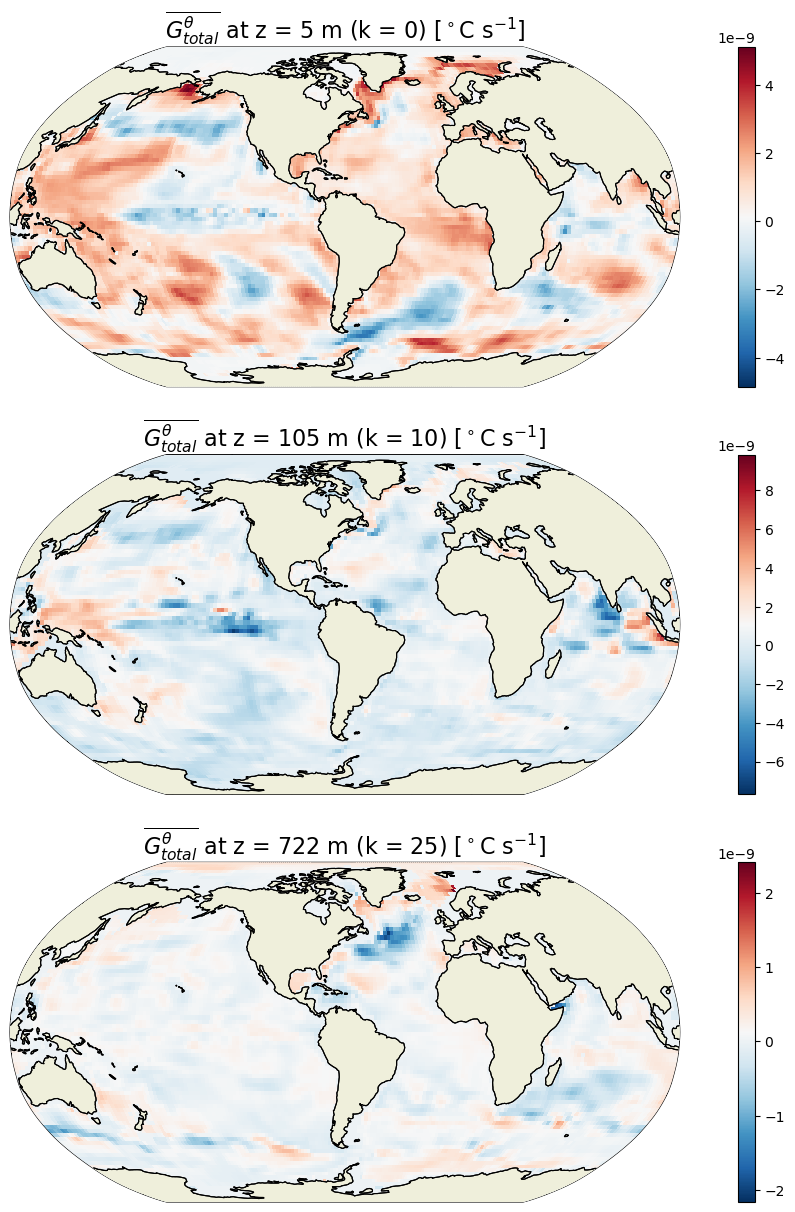

In [32]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,10,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_total_mean.isel(k=k),show_colorbar=True,
                                      cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{total}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

#### Total $\Delta \theta$

How much did ``THETA`` change over the analysis period?

In [33]:
# The number of seconds in the entire period 
seconds_in_entire_period = \
    float(ds.time_snp[-1] - ds.time_snp[0])/1e9
print ('seconds in analysis period: ', seconds_in_entire_period)

# which is also the sum of the number of seconds in each month
print('Sum of seconds in each month ', delta_t.sum().values)

seconds in analysis period:  757382400.0
Sum of seconds in each month  757382400.0


In [34]:
THETA_delta = G_total_mean*seconds_in_entire_period

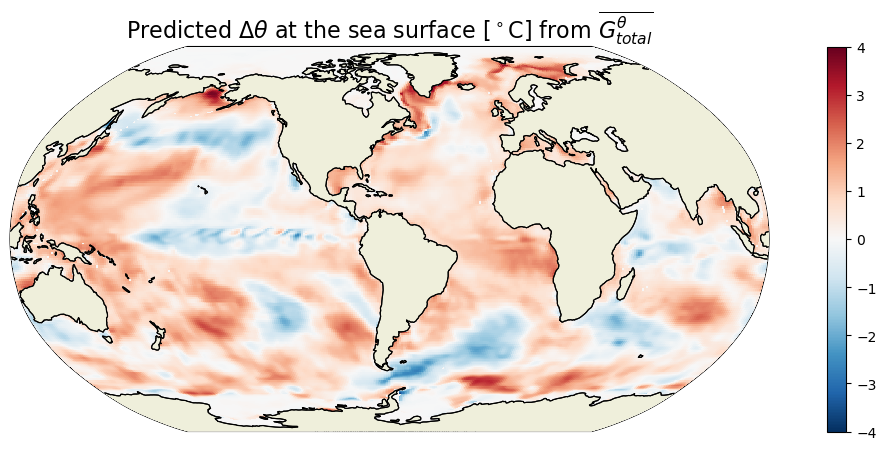

In [35]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta.isel(k=0),show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Predicted $\Delta \theta$ at the sea surface [$^\circ$C] from $\overline{G^\theta_{total}}$',fontsize=16);

We can sanity check the total ``THETA`` change that we found by multipling the time-mean ``THETA`` tendency with the number of seconds in the simulation by comparing that with the difference in ``THETA`` between the end of the last month and start of the first month. 

In [36]:
THETA_delta_method_2 = ds.THETA_snp.isel(time_snp=-1) - ds.THETA_snp.isel(time_snp=0)

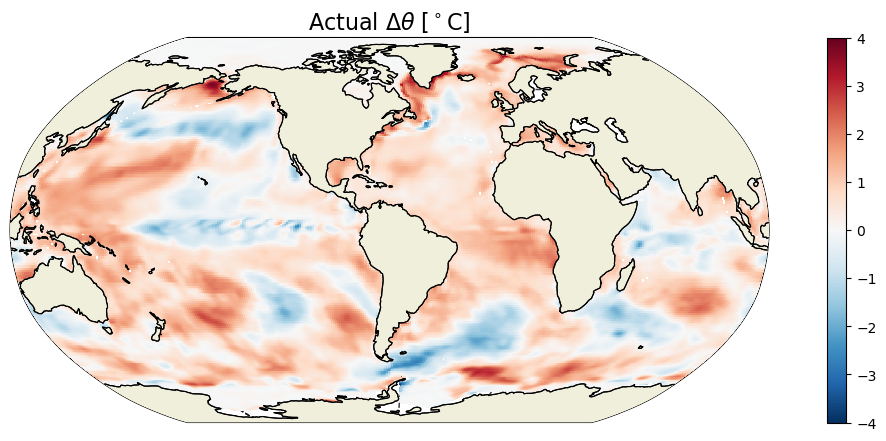

In [37]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              THETA_delta_method_2.isel(k=0),show_colorbar=True,\
                              cmin=-4, cmax=4, \
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);
plt.title(r'Actual $\Delta \theta$ [$^\circ$C]', fontsize=16);

#### Example $G^\theta_{total}$ field at a particular time

In [38]:
# get an array of YYYY, MM, DD, HH, MM, SS for 
#dETAN_dT_perSec at time index 100
curr_t_ind = 100
tmp = str(G_total.time.values[curr_t_ind])
print(tmp)

2001-05-16T12:00:00.000000000


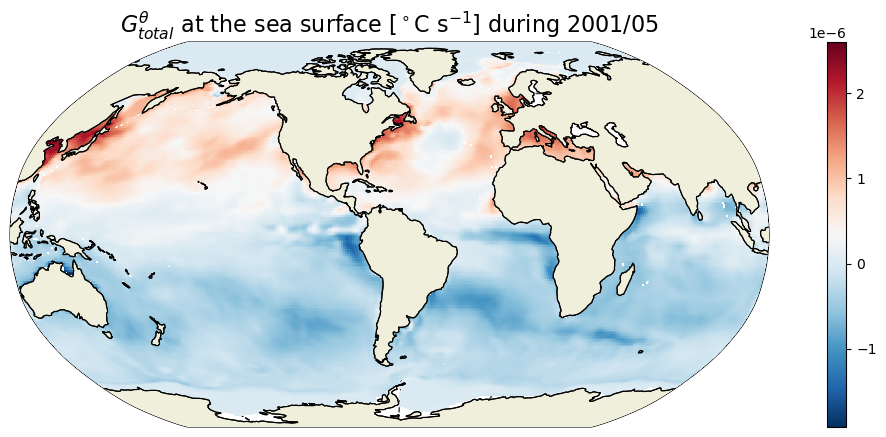

In [41]:
plt.figure(figsize=(15,5));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_total.isel(time=curr_t_ind,k=0), show_colorbar=True,
                              cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2);

plt.title(r'$G^\theta_{total}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16);

For any given month the time rate of change of ``THETA`` is strongly dependent on the season. In the above we are looking at May 2001. We see positive ``THETA`` tendency in the northern hemisphere and cooling in the southern hemisphere.

## Calculate tendency due to advective convergence ($G^{\theta}_\textrm{advection}$)

The relevant fields from the diagnostic output here are
- `ADVx_TH`: U Component Advective Flux of Potential Temperature (degC m^3/s)
- `ADVy_TH`: V Component Advective Flux of Potential Temperature (degC m^3/s)
- `ADVr_TH`: Vertical Advective Flux of Potential Temperature (degC m^3/s)

The xgcm `grid` object is then used to take the convergence of the horizontal heat advection.

> **Note**: when using at least one recent version of `xgcm` (v0.8.1), errors were triggered when calling `diff_2d_vector`.
> As an alternative, the `diff_2d_flux_llc90` function is included below.

> **Note**: For the vertical fluxes `ADVr_TH`, `DFrE_TH`, and `DFrI_TH`, we need to make sure that sequence of dimensions are consistent.
> When loading the fields use `.transpose('time','tile','k_l','j','i')`. Otherwise, the divergences will be not correct (at least for `tile = 12`).

In [49]:
def da_replace_at_indices(da,indexing_dict,replace_values):
    # replace values in xarray DataArray using locations specified by indexing_dict
    array_data = da.data
    indexing_dict_bynum = {}
    for axis,dim in enumerate(da.dims):
        if dim in indexing_dict.keys():
            indexing_dict_bynum = {**indexing_dict_bynum,**{axis:indexing_dict[dim]}}
    ndims = len(array_data.shape)
    indexing_list = [':']*ndims
    for axis in indexing_dict_bynum.keys():
        indexing_list[axis] = indexing_dict_bynum[axis]
    indexing_str = ",".join(indexing_list)

    # using exec isn't ideal, but this works for both NumPy and Dask arrays
    exec('array_data['+indexing_str+'] = replace_values')        
    
    return da


def diff_2d_flux_llc90(flux_vector_dict):
    """
    A function that differences flux variables on the llc90 grid.
    Can be used in place of xgcm's diff_2d_vector.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']
    
    u_flux_padded = u_flux.pad(pad_width={'i_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'i_g':u_flux.sizes['i_g']+1})
    v_flux_padded = v_flux.pad(pad_width={'j_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'j_g':v_flux.sizes['j_g']+1})
    
    
    # u flux padding
    for tile in range(0,3):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+3,i_g=0).data)
    for tile in range(3,6):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              v_flux.isel(tile=12-tile,j_g=0,i=slice(None,None,-1)).data)
    u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':'6','i_g':'-1'},\
                                          u_flux.isel(tile=7,i_g=0).data)
    for tile in range(7,9):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
    for tile in range(10,12):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
        
    # v flux padding
    for tile in range(0,2):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'2','j_g':'-1'},\
                                          u_flux.isel(tile=6,j=slice(None,None,-1),i_g=0).data)
    for tile in range(3,6):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'6','j_g':'-1'},\
                                          u_flux.isel(tile=10,j=slice(None,None,-1),i_g=0).data)
    for tile in range(7,10):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+3,j_g=0).data)
    for tile in range(10,13):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              u_flux.isel(tile=12-tile,j=slice(None,None,-1),i_g=0).data)
    
    # take differences
    diff_u_flux = u_flux_padded.diff('i_g')
    diff_v_flux = v_flux_padded.diff('j_g')
    
    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux.assign_coords(u_flux.coords).rename({'i_g':'i'})
    diff_v_flux = diff_v_flux.assign_coords(v_flux.coords).rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}
    
    return diff_flux_vector_dict

> **A note about memory usage**: Since the advection and diffusion calculations involve the full-depth ocean and are therefore memory intensive, we are going to be careful about limiting our memory usage at any given time: chunking our data in blocks that are sized based on our available memory, and clearing those blocks of data from our working memory space when we have finished computations with them. This is a little more complicated when using `Python` and `xarray` vs. some other computing languages, but here is the procedure we use:
> - Close the *first* dataset where the data are loaded from source files
> - Re-open the dataset so we clear any previously cached data (both the close and re-open seem to be necessary to clear the cache)
> - Carry out computations
> - Use `del` to delete any data variables where data was previously loaded using `compute`
> - Close the first dataset and repeat the cycle on the next loop iteration

> To make re-opening the dataset quicker, we will use a `pickle` object which saves the pointers created when calling `open_mfdataset` into memory. This is an important time-saver since we will be closing and re-opening this dataset a lot. For more background on why this procedure is being used, see the [Memory management in Python](https://ecco-v4-python-tutorial.readthedocs.io/Memory_management.html) tutorial.

In [50]:
# Set fluxes on land to zero (instead of NaN)
ds['ADVx_TH'] = ds.ADVx_TH.where(ecco_grid.hFacW.values > 0,0)
ds['ADVy_TH'] = ds.ADVy_TH.where(ecco_grid.hFacS.values > 0,0)
ds['ADVr_TH'] = ds.ADVr_TH.where(ecco_grid.hFacC.values > 0,0)

# transpose dimensions for xgcm (see note below)
ds['ADVr_TH'] = ds.ADVr_TH.transpose('time','tile','k_l','j','i')

# re-chunk arrays for better performance
ds['ADVx_TH'] = ds['ADVx_TH'].chunk({'time':1,'k':-1,'tile':-1,'j':-1,'i_g':-1})
ds['ADVy_TH'] = ds['ADVy_TH'].chunk({'time':1,'k':-1,'tile':-1,'j_g':-1,'i':-1})
ds['ADVr_TH'] = ds['ADVr_TH'].chunk({'time':1,'tile':-1,'k_l':-1,'j':-1,'i':-1})


# create pickled object with pointers to original flux files
import pickle
ecco_vars_int_pickled = pickle.dumps(ecco_vars_int)

# close ecco_vars_int dataset
ecco_vars_int.close()

> **Note**: In case of the volume budget (and salinity conservation), the surface forcing (`oceFWflx`) is already included at the top level (`k_l = 0`) in ``WVELMASS``.  Thus, to keep the surface forcing term explicitly represented, one needs to zero out the values of ``WVELMASS`` at the surface so as to avoid double counting (see the [Volume budget closure](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_v4_Volume_budget_closure.html) tutorial). This is not the case for the heat budget. `ADVr_TH` does not include the sea surface forcing. Thus, the vertical advective flux (at the air-sea interface) should not be zeroed out.

In [51]:
### Original code to compute G_advection is commented below
### (can use this if xgcm.diff_2d_vector is working properly
### and memory constraints allow)


# # compute horizontal components of flux divergence
# ADVxy_diff = grid.diff_2d_vector({'X' : ds.ADVx_TH, 'Y' : ds.ADVy_TH}, boundary = 'fill')

# # Convergence of horizontal advection (degC m^3/s)
# adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))

# # Convergence of vertical advection (degC m^3/s)
# adv_vConvH = grid.diff(ADVr_TH, 'Z', boundary='fill')

## Sum horizontal and vertical convergences and divide by volume (degC/s)
# G_advection = (adv_hConvH + adv_vConvH)/vol


### End of original code block


def G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None):
    """Computes advection tendency for given time and k indices (k indices must be continuous, without gaps)"""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    if isinstance(k_isel,type(None)):
        k_isel = np.arange(0,ds.sizes['k'])

    if len(k_isel) > 1:
        if (np.nanmin(np.diff(np.asarray(k_isel))) < 1) or (np.nanmax(np.diff(np.asarray(k_isel))) > 1):
            raise ValueError('k_isel is not monotonically increasing or not continuous')        

    
    # re-open source dataset
    ecco_vars_int = pickle.loads(ecco_vars_int_pickled)
        
    ## compute horizontal convergence

    ADVx_TH = ds.ADVx_TH.isel(time=time_isel,k=k_isel).compute()
    ADVy_TH = ds.ADVy_TH.isel(time=time_isel,k=k_isel).compute()
    ADVxy_diff = diff_2d_flux_llc90({'X': ADVx_TH,\
                                     'Y': ADVy_TH})
    
    
    # Convergence of horizontal advection (degC m^3/s)
    adv_hConvH = (-(ADVxy_diff['X'] + ADVxy_diff['Y']))
    
    # transpose dimensions
    adv_hConvH = adv_hConvH.transpose('time','tile','k','j','i')
    
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    adv_hConvH = adv_hConvH.assign_coords({'time':ds.time[time_isel].data}).compute()
        
    ## compute vertical convergence

    if k_isel[-1] == ds.sizes['k']-1:
        ADVr_TH = ds.ADVr_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0).compute()        
    else:
        ADVr_TH = ds.ADVr_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1)).compute()
    adv_vConvH = ADVr_TH.diff('k_l').rename({'k_l':'k'})
    adv_vConvH = adv_vConvH.assign_coords({'k':ds.k[k_isel].data})
        
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    adv_vConvH = adv_vConvH.assign_coords({'time':ds.time[time_isel].data}).compute()
        

    ## Sum horizontal and vertical convergences and divide by volume (degC/s)
    G_advection = ((adv_hConvH + adv_vConvH)/vol).compute()
    
    # delete the variables where data was actually loaded into memory
    del ADVx_TH
    del ADVy_TH
    del adv_hConvH
    del ADVr_TH
    del adv_vConvH

    # close the original dataset where the fluxes were loaded from the source files (needed to clear the data from cache)
    ecco_vars_int.close()
    
    return G_advection



def monthly_tmean_aggregate(function,ds,ecco_vars_int_pickled,vol,month_length_weights,time_chunksize=1,time_isel=None,k_isel=None):
    """Compute time mean by cumulatively summing array over time_isel indices, weighted by month length.
       Includes variable time_chunksize to help us manage different memory environments;
       larger chunks run faster but require more system memory."""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    
    for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
        curr_time_isel = time_isel[(time_chunksize*time_chunk):np.fmin(time_chunksize*(time_chunk+1),len(time_isel))]
        curr_array_computed = function(ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel)
        if time_chunk == 0:
            array_tmean = (month_length_weights.isel(time=curr_time_isel)*curr_array_computed).sum('time').compute()            
        else:
            array_tmean += (month_length_weights.isel(time=curr_time_isel)*curr_array_computed).sum('time').compute()            

        del curr_array_computed        
    
    return array_tmean

### Plot the time-mean $G^{\theta}_\textrm{advection}$

In [52]:
import psutil
mem_avail = psutil.virtual_memory().available
print('Available memory:',mem_avail/(10**9),'GB')

# chunk size to use when computing time mean with monthly_tmean_aggregate (not the same as dask chunksize)
time_chunksize = int(np.round(mem_avail/(2**28)))
time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
print('Using time_chunksize =',time_chunksize)

Available memory: 4.906917888 GB
Using time_chunksize = 18


In [ ]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                                      monthly_tmean_aggregate(G_advection_compute,\
                                                              ds,ecco_vars_int_pickled,vol,month_length_weights,\
                                                              time_chunksize=time_chunksize,k_isel=[k]),\
                                      show_colorbar=True,
                                      cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{advection}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

### Example $G^{\theta}_\textrm{advection}$ field at a particular time

In [ ]:
curr_t_ind = 100
tmp = str(ds.time.values[curr_t_ind])
print(tmp)

In [ ]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                              G_advection_compute(ds,ecco_vars_int_pickled,vol,time_isel=[curr_t_ind],k_isel=[0]),\
                              show_colorbar=True,
                              cmin=-1e-6, cmax=1e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{advection}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16)
plt.show()

## Calculate tendency due to diffusive convergence ($G^{\theta}_\textrm{diffusion}$)

The relevant fields from the diagnostic output here are
- `DFxE_TH`: U Component Diffusive Flux of Potential Temperature (degC m^3/s)
- `DFyE_TH`: V Component Diffusive Flux of Potential Temperature (degC m^3/s)
- `DFrE_TH`: Vertical Diffusive Flux of Potential Temperature (Explicit part) (degC m^3/s)
- `DFrI_TH`: Vertical Diffusive Flux of Potential Temperature (Implicit part) (degC m^3/s)
> **Note**: Vertical diffusion has both an explicit (`DFrE_TH`) and an implicit (`DFrI_TH`) part.

As with advective fluxes, we use the xgcm `grid` object to calculate the convergence of horizontal heat diffusion.

In [ ]:
# Set fluxes on land to zero (instead of NaN)
ds['DFxE_TH'] = ds.DFxE_TH.where(ecco_grid.hFacW.values > 0,0)
ds['DFyE_TH'] = ds.DFyE_TH.where(ecco_grid.hFacS.values > 0,0)
ds['DFrE_TH'] = ds.DFrE_TH.where(ecco_grid.hFacC.values > 0,0)
ds['DFrI_TH'] = ds.DFrI_TH.where(ecco_grid.hFacC.values > 0,0)

# tranpose dimensions
ds['DFrE_TH'] = ds.DFrE_TH.transpose('time','tile','k_l','j','i')
ds['DFrI_TH'] = ds.DFrI_TH.transpose('time','tile','k_l','j','i')

# re-chunk arrays for better performance
ds['DFxE_TH'] = ds['DFxE_TH'].chunk({'time':12,'k':-1,'tile':-1,'j':-1,'i_g':-1})
ds['DFyE_TH'] = ds['DFyE_TH'].chunk({'time':12,'k':-1,'tile':-1,'j_g':-1,'i':-1})
ds['DFrE_TH'] = ds['DFrE_TH'].chunk({'time':12,'k_l':-1,'tile':-1,'j':-1,'i':-1})
ds['DFrI_TH'] = ds['DFrI_TH'].chunk({'time':12,'k_l':-1,'tile':-1,'j':-1,'i':-1})

In [ ]:
### Original code to compute G_diffusion is commented below
### (can use this if xgcm.diff_2d_vector is working properly
### and memory constraints allow)


# # compute horizontal components of flux divergence
# DFxyE_diff = grid.diff_2d_vector({'X' : ds.DFxE_TH, 'Y' : ds.DFyE_TH}, boundary = 'fill')

# # Convergence of horizontal diffusion (degC m^3/s)
# dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

# # Convergence of vertical diffusion (degC m^3/s)
# dif_vConvH = grid.diff(DFrE_TH + DFrI_TH, 'Z', boundary='fill')

# # Sum horizontal and vertical convergences and divide by volume (degC/s)
# G_diffusion = (dif_hConvH + dif_vConvH)/vol


### End of original code block


# complete horizontal divergence calculation, 12 time indices (1 year) at a time

def G_diffusion_compute(ds,ecco_vars_int_pickled,vol,time_isel=None,k_isel=None):
    """Computes diffusion tendency for given time and k indices (k indices must be continuous, without gaps)"""

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    if isinstance(k_isel,type(None)):
        k_isel = np.arange(0,ds.sizes['k'])

    if len(k_isel) > 1:
        if (np.nanmin(np.diff(np.asarray(k_isel))) < 1) or (np.nanmax(np.diff(np.asarray(k_isel))) > 1):
            raise ValueError('k_isel is not monotonically increasing or not continuous')        

    
    # re-open source dataset
    ecco_vars_int = pickle.loads(ecco_vars_int_pickled)
    
    ## compute horizontal convergence

    DFxE_TH = ds.DFxE_TH.isel(time=time_isel,k=k_isel).compute()
    DFyE_TH = ds.DFyE_TH.isel(time=time_isel,k=k_isel).compute()
    DFxyE_diff = diff_2d_flux_llc90({'X': DFxE_TH,\
                                     'Y': DFyE_TH})
    
    # Convergence of horizontal advection (degC m^3/s)
    dif_hConvH = (-(DFxyE_diff['X'] + DFxyE_diff['Y']))

    # transpose dimensions
    dif_hConvH = dif_hConvH.transpose('time','tile','k','j','i')
    
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    dif_hConvH = dif_hConvH.assign_coords({'time':ds.time[time_isel].data}).compute()
    
    ## compute vertical convergence
    
    if k_isel[-1] == ds.sizes['k']-1:
        DFrE_TH = ds.DFrE_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0).compute()
        DFrI_TH = ds.DFrI_TH.isel(time=time_isel,k_l=k_isel).pad(pad_width={'k_l':(0,1)},mode='constant',constant_values=0).compute()        
    else:
        DFrE_TH = ds.DFrE_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1)).compute()
        DFrI_TH = ds.DFrI_TH.isel(time=time_isel,k_l=np.append(k_isel,k_isel[-1]+1)).compute()        
    dif_vConvH = (DFrE_TH + DFrI_TH).diff('k_l').rename({'k_l':'k'})
    dif_vConvH = dif_vConvH.assign_coords({'k':ds.k[k_isel].data})
    
    # restore time coordinate to DataArray if needed (can be lost in xgcm.diff_2d_vector operation)
    dif_vConvH = dif_vConvH.assign_coords({'time':ds.time[time_isel].data}).compute()
        
    ## Sum horizontal and vertical convergences and divide by volume (degC/s)
    G_diffusion = ((dif_hConvH + dif_vConvH)/vol).compute()
    
    # delete the variables where data was actually loaded into memory
    del DFxE_TH
    del DFyE_TH
    del dif_hConvH
    del DFrE_TH
    del DFrI_TH
    del dif_vConvH

    # close the original dataset where the fluxes were loaded from the source files (needed to clear the data from cache)
    ecco_vars_int.close()
    
    return G_diffusion

### Plot the time-mean $G^{\theta}_\textrm{diffusion}$

In [ ]:
mem_avail = psutil.virtual_memory().available
print('Available memory:',mem_avail/(10**9),'GB')

# chunk size to use when computing time mean with monthly_tmean_aggregate (not the same as dask chunksize)
time_chunksize = int(np.round(mem_avail/(2**28)))
time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
print('Using time_chunksize =',time_chunksize)

In [ ]:
plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                                      monthly_tmean_aggregate(G_diffusion_compute,\
                                                              ds,ecco_vars_int_pickled,vol,month_length_weights,\
                                                              time_chunksize=time_chunksize,k_isel=[k]),\
                                      show_colorbar=True,
                                      cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{diffusion}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

### Example $G^{\theta}_\textrm{diffusion}$ field at a particular time

In [ ]:
curr_t_ind = 100
tmp = str(ds.time.values[curr_t_ind])
print(tmp)

In [ ]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                              G_diffusion_compute(ds,ecco_vars_int_pickled,vol,time_isel=[curr_t_ind],k_isel=[0]),\
                              show_colorbar=True,
                              cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{diffusion}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16)
plt.show()

## Calculate tendency due to forcing ($G^{\theta}_\textrm{forcing}$)
Finally, we evaluate the local forcing term due to surface heat and geothermal fluxes.

### Surface heat flux
For the surface contribution, there are two relevant model diagnostics:
- `TFLUX`: total heat flux (match heat-content variations) (W/m^2)
- `oceQsw`: net Short-Wave radiation (+=down) (W/m^2)

#### Defining terms needed for evaluating surface heat forcing

In [ ]:
Z = ecco_grid.Z.compute()
RF = np.concatenate([ecco_grid.Zp1.values[:-1],[np.nan]])

>**Note**: `Z` and `Zp1` are used in deriving surface heat penetration. MATLAB code uses `RF` from `mygrid` structure.

In [ ]:
q1 = R*np.exp(1.0/zeta1*RF[:-1]) + (1.0-R)*np.exp(1.0/zeta2*RF[:-1])
q2 = R*np.exp(1.0/zeta1*RF[1:]) + (1.0-R)*np.exp(1.0/zeta2*RF[1:])

In [ ]:
# Correction for the 200m cutoff
zCut = np.where(Z < -200)[0][0]
q1[zCut:] = 0
q2[zCut-1:] = 0

In [ ]:
# Create xarray data arrays
q1 = xr.DataArray(q1,coords=[Z.k],dims=['k'])
q2 = xr.DataArray(q2,coords=[Z.k],dims=['k'])

#### Compute vertically penetrating flux
Given the penetrating nature of the shortwave term, to properly evaluate the local forcing term, `oceQsw` must be removed from `TFLUX` (which contains the net latent, sensible, longwave, and shortwave contributions) and redistributed vertically.

In [ ]:
## Land masks
# Make copy of hFacC
mskC = ecco_grid.hFacC.copy(deep=True).compute()

# Change all fractions (ocean) to 1. land = 0
mskC.values[mskC.values>0] = 1

In [ ]:
# Shortwave flux below the surface (W/m^2)
forcH_subsurf = ((q1*(mskC==1)-q2*(mskC.shift(k=-1)==1))*ds.oceQsw).transpose('time','tile','k','j','i')

In [ ]:
# Surface heat flux (W/m^2)
forcH_surf = ((ds.TFLUX - (1-(q1[0]-q2[0]))*ds.oceQsw)\
              *mskC[0]).transpose('time','tile','j','i').assign_coords(k=0).expand_dims('k')

In [ ]:
# Full-depth sea surface forcing (W/m^2)
forcH = xr.concat([forcH_surf,forcH_subsurf[:,:,1:]], dim='k').transpose('time','tile','k','j','i')

### Geothermal flux

The geothermal flux contribution is not accounted for in any of the standard model diagnostics provided as output. Rather, this term, which is time invariant, is provided in the input file `geothermalFlux.bin` contained in the ancillary data archive. This archive can be downloaded from [PO.DAAC](https://archive.podaac.earthdata.nasa.gov/podaac-ops-cumulus-protected/ECCO_L4_ANCILLARY_DATA_V4R4/ancillary_data_input_forcing_ECCO_V4r4.tar.gz), though accessing it there requires downloading a much larger tarball of files (~192 GB). So, for the time being, the `geothermalFlux.bin` file is also stored on the tutorial Github and can be downloaded [here](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/raw/master/misc/geothermalFlux.bin).

> **Note**: The code cell below assumes `geothermalFlux.bin` has been placed in `~/Downloads`, or is in the cloned GitHub repository under `~/ECCO-v4-Python-Tutorial/misc` or `~/git_repos/ECCO-v4-Python-Tutorial/misc`. Change the directory `geoflx_dir` as needed.

In [ ]:
# Load the geothermal heat flux using the routine 'read_llc_to_tiles'.
geoflx_filename = 'geothermalFlux.bin'
if exists(join(user_home_dir,'Downloads',geoflx_filename)):
    geoflx_dir = join(user_home_dir,'Downloads')
elif exists(join(user_home_dir,'ECCO-v4-Python-Tutorial','misc',geoflx_filename)):
    geoflx_dir = join(user_home_dir,'ECCO-v4-Python-Tutorial','misc')
elif exists(join(user_home_dir,'git_repos','ECCO-v4-Python-Tutorial','misc',geoflx_filename)):
    geoflx_dir = join(user_home_dir,'git_repos','ECCO-v4-Python-Tutorial','misc')
else:
    raise FilePathError('Can not locate '+geoflx_filename+' in default directories.\n'\
                        +'Please specify geoflx_dir.')
# geoflx_dir = join(user_home_dir,'Downloads')
geoflx = ecco.read_llc_to_tiles(geoflx_dir, 'geothermalFlux.bin')

The geothermal flux dataset needs to be saved as an xarray data array with the same format as the model output.

In [ ]:
# Convert numpy array to an xarray DataArray with matching dimensions as the monthly mean fields
geoflx_llc = xr.DataArray(geoflx,coords={'tile': ecco_monthly_mean.tile.values,
                                         'j': ecco_monthly_mean.j.values,
                                         'i': ecco_monthly_mean.i.values},dims=['tile','j','i'])

In [ ]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, geoflx_llc,show_colorbar=True,cmap='magma', 
                              user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'Geothermal heat flux [W m$^{-2}$]', fontsize=16)
plt.show()

Geothermal flux needs to be a three dimensional field since the sources are distributed along the ocean floor at various depths. This requires a three dimensional mask.

In [ ]:
# Create 3d bathymetry mask
mskC_shifted = mskC.shift(k=-1)

mskC_shifted.values[-1,:,:,:] = 0
mskb = mskC - mskC_shifted

# Create 3d field of geothermal heat flux
geoflx3d = geoflx_llc * mskb.transpose('k','tile','j','i')
GEOFLX = geoflx3d.transpose('k','tile','j','i')
GEOFLX.attrs = {'standard_name': 'GEOFLX','long_name': 'Geothermal heat flux','units': 'W/m^2'}

### Total forcing ($G^{\theta}_\textrm{forcing}$)

In [ ]:
# Add geothermal heat flux to forcing field and convert from W/m^2 to degC/s
G_forcing = ((forcH + GEOFLX)/(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)

### Plot the time-mean $G^{\theta}_\textrm{forcing}$

In [ ]:
G_forcing_mean = (G_forcing*month_length_weights).sum('time')

In [ ]:
%%time

plt.figure(figsize=(15,15))

for idx, k in enumerate([0,1,25]):
    p = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing_mean.isel(k=k),show_colorbar=True,
                                      cmin=-3e-6, cmax=3e-6, cmap='RdBu_r', user_lon_0=-67, dx=2, dy=2, 
                                      subplot_grid=[3,1,idx+1]);
    p[1].set_title(r'$\overline{G^\theta_{forcing}}$ at z = %i m (k = %i) [$^\circ$C s$^{-1}$]'\
                   %(np.round(-ecco_grid.Z[k].values),k), fontsize=16)

$\overline{G^\theta_{forcing}}$ is focused at the sea surface and much smaller (essentially zero) at depth. $\overline{G^\theta_{forcing}}$ is negative for most of the ocean (away from the equator). The spatial pattern in the surface forcing is the same as for diffusion but with opposite sign (see maps for $\overline{G^\theta_{diffusion}}$ above). This makes sense as forcing is to a large extent balanced by diffusion within the mixed layer.

### Example $G^{\theta}_\textrm{forcing}$ field at a particular time

In [64]:
curr_t_ind = 100
tmp = str(G_forcing.time.values[curr_t_ind])
print(tmp)

2001-05-16T12:00:00.000000000


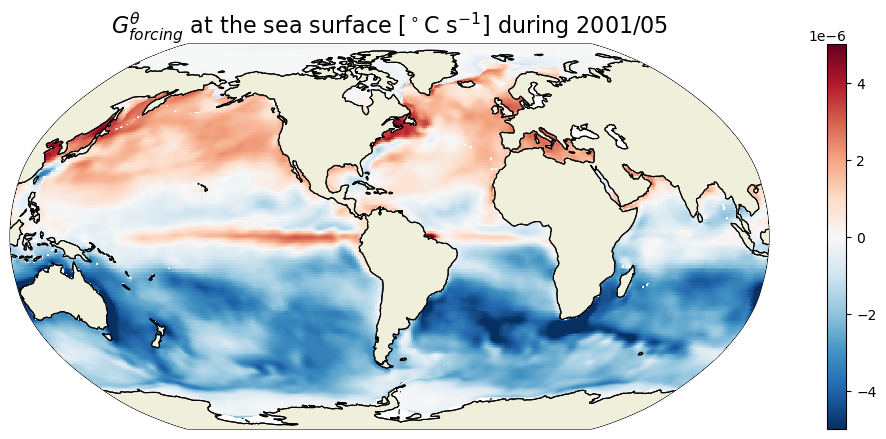

In [65]:
plt.figure(figsize=(15,5));

ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, G_forcing.isel(time=curr_t_ind,k=0),show_colorbar=True,
                              cmin=-5e-6, cmax=5e-6, cmap='RdBu_r', user_lon_0=-67, dx=0.2, dy=0.2)
plt.title(r'$G^\theta_{forcing}$ at the sea surface [$^\circ$C s$^{-1}$] during ' + 
          str(tmp)[0:4] +'/' + str(tmp)[5:7], fontsize=16)
plt.show()

## Save to dataset
Now that we have all the terms evaluated, let's save them to a dataset. Here are two examples:
- Zarr is a new format that is used for cloud storage.
- Netcdf is the more traditional format that most people are familiar with.

When saving this heat budget dataset, the zarr file is ~15 GB, while the NetCDF file is ~53 GB. So zarr can be more efficient for storage.

### Add all variables to a new dataset

In [66]:
varnames = ['G_total','G_advection','G_diffusion','G_forcing']

G_total = G_total.transpose('time','tile','k','j','i')

adv_diff_written = True

ds_budg = xr.Dataset(data_vars={})
for varname in varnames:
    if varname not in globals():
        # create empty dask arrays for G_advection and G_diffusion (to be written later)
        import dask.array as da
        ds_budg[varname] = (['time','tile','k','j','i'],\
                            da.empty((ds.sizes['time'],13,50,90,90),dtype='float32',\
                                    chunks=(1,13,50,90,90)))
        adv_diff_written = False
    else:
        ds_budg[varname] = globals()[varname].chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})        

In [67]:
# Add surface forcing (degC/s)
ds_budg['Qnet'] = ((forcH /(rhoconst*c_p))\
                  /(ecco_grid.hFacC*ecco_grid.drF)).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

In [68]:
# Add shortwave penetrative flux (degC/s)
#Since we only are interested in the subsurface heat flux we need to zero out the top cell
SWpen = ((forcH_subsurf /(rhoconst*c_p))/(ecco_grid.hFacC*ecco_grid.drF)).where(forcH_subsurf.k>0).fillna(0.)
ds_budg['SWpen'] = SWpen.where(ecco_grid.hFacC>0).chunk(chunks={'time':1,'tile':13,'k':50,'j':90,'i':90})

> **Note**: `Qnet` and `SWpen` are included in `G_forcing` and are not necessary to close the heat budget. 

In [69]:
ds_budg.time.encoding = {}
ds_budg = ds_budg.reset_coords(drop=True)

### Save to zarr

In [70]:
import zarr

In [71]:
# save_dir is set to ~/Downloads below;
# change if you want to save somewhere else
save_dir = join(user_home_dir,'Downloads')

# first query how much storage is free
# the zarr file will occupy ~15 GB, so require 20 GB free storage as a buffer

import shutil
free_storage = shutil.disk_usage(save_dir).free
print(f'Free storage: {free_storage/(10**9)} GB')

# query how much memory is available
# (influences how this large archive will be computed and stored)
mem_avail = psutil.virtual_memory().available
print('Available memory:',mem_avail/(10**9),'GB')

Free storage: 53.796531677246094 GB
Available memory: 2.313945770263672 GB


In [72]:
from dask.diagnostics import ProgressBar

In [73]:
%pdb on

### Original code to save dataset to zarr archive

# zarr_save_location = join(save_dir,'eccov4r4_budg_heat')
# ds.to_zarr(zarr_save_location)

### End of original code block


def zarr_archive_tloop(function,save_location,varname,\
                       ds,ecco_vars_int_pickled,vol,time_chunksize=1,time_isel=None,k_isel=None):
    """
    Compute array using function and save to zarr archive, 
    by looping through time chunks of size time_chunksize.
    This has cleaner memory usage than just relying on dask chunking.
    """

    if isinstance(time_isel,type(None)):
        time_isel = np.arange(0,ds.sizes['time'])
    
    for time_chunk in range(int(np.ceil(len(time_isel)/time_chunksize))):
        if exists(save_location):
            ds_to_write = xr.open_zarr(save_location)
        curr_time_isel = time_isel[(time_chunksize*time_chunk):np.fmin(time_chunksize*(time_chunk+1),len(time_isel))]
        ds_to_write[varname] = da_replace_at_indices(ds_to_write[varname],\
                                                    {'time':str(curr_time_isel[0])+':'+str(curr_time_isel[-1]+1)},\
                                                    function(ds,ecco_vars_int_pickled,vol,time_isel=curr_time_isel,k_isel=k_isel))
        ds_to_write[varname].to_dataset().to_zarr(save_location,mode="a")
        ds_to_write.close()


# the zarr archive will occupy ~15 GB, so require 20 GB free storage as a buffer
zarr_save_location = join(save_dir,'eccov4r4_budg_heat')
if free_storage >= 20*(10**9):
    # chunk size to use when computing G_advection and G_diffusion (not the same as dask chunksize)
    time_chunksize = int(np.round(mem_avail/(10**9)))
    # time_chunksize = ds.sizes['time']
    time_chunksize = np.fmin(np.fmax(time_chunksize,1),ds.sizes['time'])
    print('Using time_chunksize =',time_chunksize)
    if mem_avail >= 20*(10**9):
        if not adv_diff_written:
            ds_budg['G_advection'] = G_advection_compute(ds,ecco_vars_int_pickled,vol)
            ds_budg['G_diffusion'] = G_diffusion_compute(ds,ecco_vars_int_pickled,vol)
        with ProgressBar():
            ds_budg.to_zarr(zarr_save_location)
    else:
        ecco_vars_int.close()
        for varname in ds_budg.data_vars:
            ds_budg[varname].to_dataset().to_zarr(zarr_save_location,mode="a")                
            if varname in ['G_advection','G_diffusion']:                
                zarr_archive_tloop(eval(varname+'_compute'),zarr_save_location,varname,\
                                   ds,ecco_vars_int_pickled,vol,time_chunksize=time_chunksize)
else:
    print('Insufficient storage to save global budget terms to disk as zarr')

Automatic pdb calling has been turned ON
Using time_chunksize = 2


### Save to netcdf

In [74]:
# to save budget as netcdf, set save_netcdf = True
save_netcdf = False

# the netcdf file will occupy ~53 GB, so require 60 GB free storage as a buffer
if save_netcdf:
    if free_storage >= 60*(10**9):
        with ProgressBar():
            ds.to_netcdf(join(save_dir,'eccov4r4_budg_heat.nc'), format='NETCDF4')
    else:
        print('Insufficient storage to save global budget terms to disk as netcdf')

## Load budget variables from file
After having saved the budget terms to file, we can load the dataset like this

In [75]:
# Load terms from zarr dataset
G_budget = xr.open_zarr(join(save_dir,'eccov4r4_budg_heat'))
G_total = G_budget.G_total
G_advection = G_budget.G_advection
G_diffusion = G_budget.G_diffusion
G_forcing = G_budget.G_forcing
Qnet = G_budget.Qnet
SWpen = G_budget.SWpen

Or if you saved it as a netcdf file:
``` python
# Load terms from netcdf file
G_budget = xr.open_mfdataset(join(save_dir,'eccov4r4_budg_heat.nc'))
G_total_tendency = G_budget.G_total_tendency
G_advection = G_budget.G_advection
G_diffusion = G_budget.G_diffusion
G_forcing = G_budget.G_forcing
Qnet = G_budget.Qnet
```

## Comparison between LHS and RHS of the budget equation

In [76]:
# Total convergence
ConvH = G_advection + G_diffusion

In [77]:
# Sum of terms in RHS of equation
rhs = ConvH + G_forcing

### Map of residuals

In [78]:
res = ((rhs-G_total).sum(dim='k')*month_length_weights).sum(dim='time').compute()

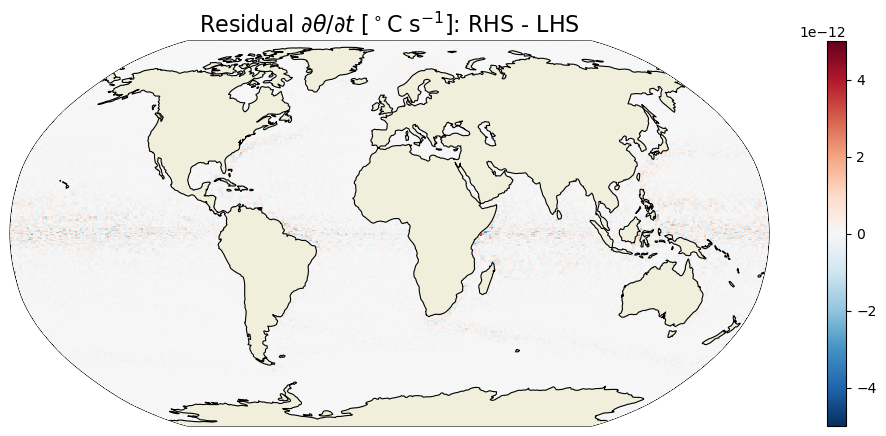

In [79]:
plt.figure(figsize=(15,5))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res,
                              cmin=-5e-12, cmax=5e-12, show_colorbar=True, cmap='RdBu_r',dx=0.2, dy=0.2)
plt.title(r'Residual $\partial \theta / \partial t$ [$^\circ$C s$^{-1}$]: RHS - LHS', fontsize=16)
plt.show()

The residual (summed over depth and time) is essentially zero everywhere. What if we omit the geothermal heat flux?

In [80]:
# Residual when omitting geothermal heat flux
res_geo = ((ConvH + Qnet - G_total).sum(dim='k')*month_length_weights).sum(dim='time').compute()

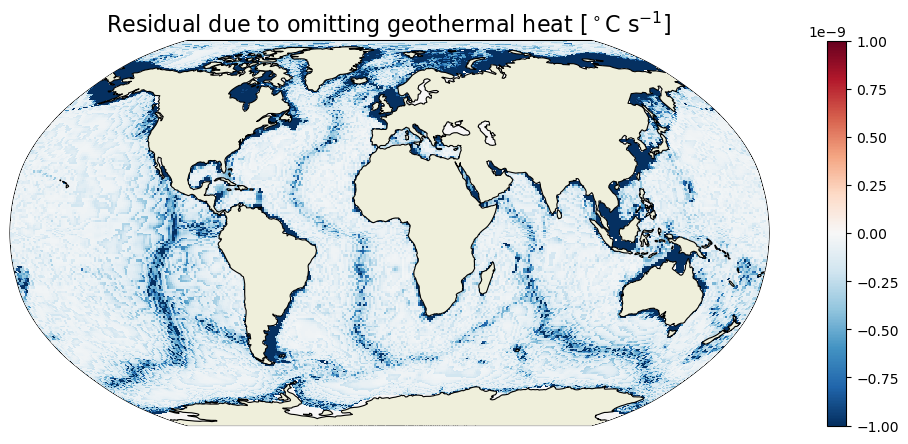

In [81]:
plt.figure(figsize=(15,5))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res_geo,
                              cmin=-1e-9, cmax=1e-9, show_colorbar=True, cmap='RdBu_r', dx=0.2, dy=0.2)
plt.title(r'Residual due to omitting geothermal heat [$^\circ$C s$^{-1}$] ', fontsize=16)
plt.show()

We see that the contribution from geothermal flux in the heat budget is well above the residual (by *three orders of magnitude*).

In [82]:
# Residual when omitting shortwave penetrative heat flux
res_sw = (rhs-SWpen-G_total).sum(dim='k').sum(dim='time').compute()

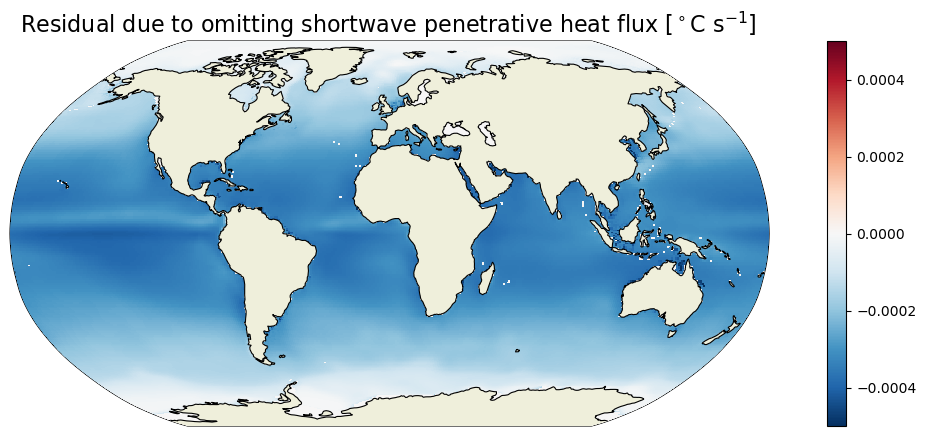

In [83]:
plt.figure(figsize=(15,5))
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, res_sw,
                              cmin=-5e-4, cmax=5e-4, show_colorbar=True, cmap='RdBu_r', dx=0.2, dy=0.2)
plt.title(r'Residual due to omitting shortwave penetrative heat flux [$^\circ$C s$^{-1}$] ', fontsize=16)
plt.show()

In terms of subsurface heat fluxes, shortwave penetration represents a much larger heat flux compared to geothermal heat flux (by around *three orders of magnitude*).

### Histogram of residuals
We can look at the distribution of residuals to get a little more confidence.

In [84]:
tmp = np.abs(res).values.ravel()

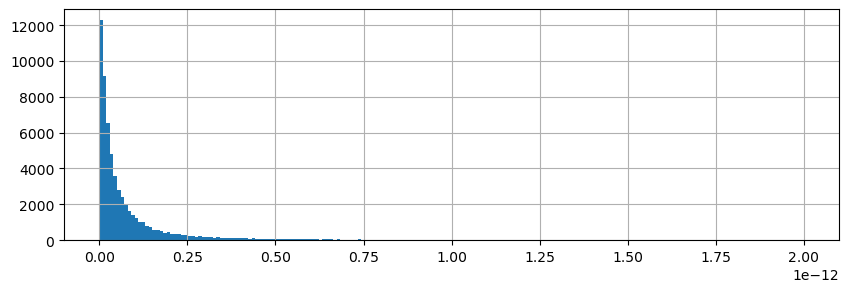

In [85]:
plt.figure(figsize=(10,3));

plt.hist(tmp[tmp > 0],np.linspace(0, 2.e-12, 200));
plt.grid()

Summing residuals vertically and temporally yields < $10^{-12}$ $^\circ$C s$^{-1}$ for most grid points.

## Heat budget closure through time

### Global average budget closure

Another way of demonstrating heat budget closure is to show the global spatially-averaged `THETA` tendency terms 

In [86]:
# Compute volume (m^3) if not already computed
if 'vol' not in locals():
    vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()
elif not isinstance(vol,np.ndarray):
    vol = (ecco_grid.rA*ecco_grid.drF*ecco_grid.hFacC).transpose('tile','k','j','i').compute()

# Take volume-weighted mean of these terms
tmp_a=(G_total*vol).sum(dim=('k','i','j','tile')).compute()/vol.sum()
tmp_b=(G_advection*vol).sum(dim=('k','i','j','tile')).compute()/vol.sum()
tmp_c=(G_diffusion*vol).sum(dim=('k','i','j','tile')).compute()/vol.sum()
tmp_d=(G_forcing*vol).sum(dim=('k','i','j','tile')).compute()/vol.sum()

# tmp_e=(rhs*vol).sum(dim=('k','i','j','tile')).compute()/vol.sum()
# # save time by not re-computing G_advection, G_diffusion, G_forcing to compute rhs
tmp_e = tmp_b + tmp_c + tmp_d

# Result is five time series
tmp_a.dims

('time',)

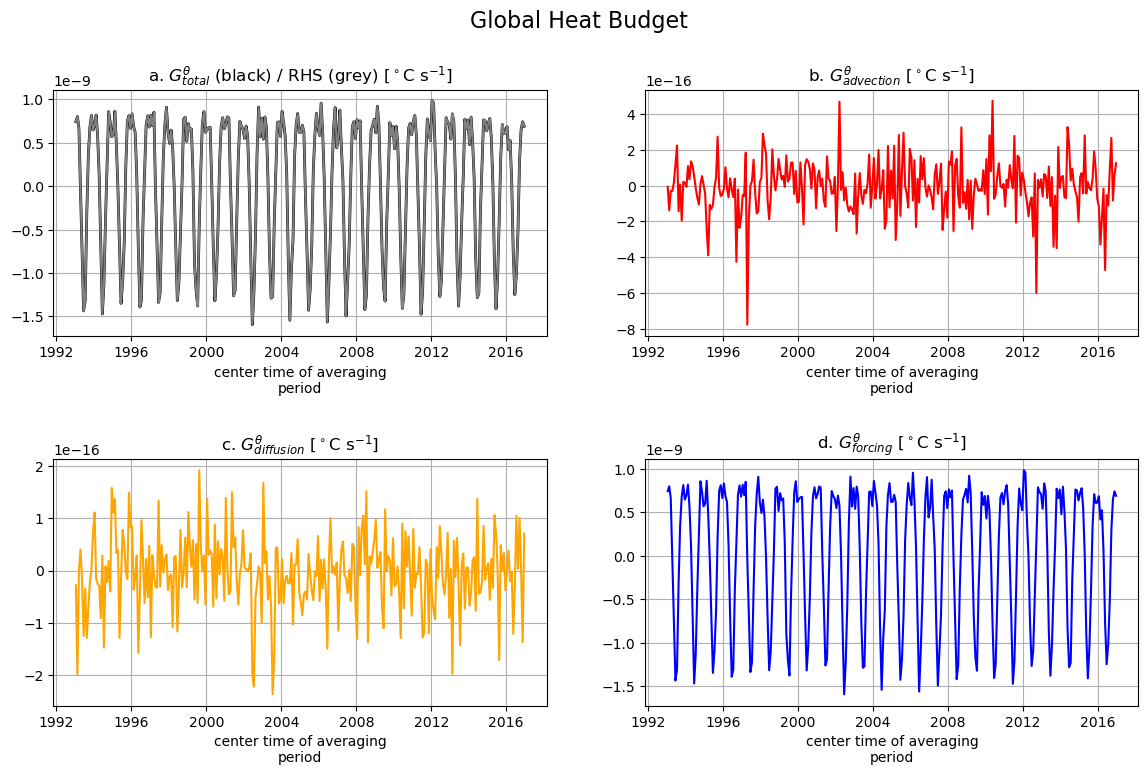

In [87]:
fig, axs = plt.subplots(2, 2, figsize=(14,8))

plt.sca(axs[0,0])
tmp_a.plot(color='k',lw=2)
tmp_e.plot(color='grey')
axs[0,0].set_title(r'a. $G^\theta_{total}$ (black) / RHS (grey) [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[0,1])
tmp_b.plot(color='r')
axs[0,1].set_title(r'b. $G^\theta_{advection}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,0])
tmp_c.plot(color='orange')
axs[1,0].set_title(r'c. $G^\theta_{diffusion}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,1])
tmp_d.plot(color='b')
axs[1,1].set_title(r'd. $G^\theta_{forcing}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Global Heat Budget', fontsize=16);

When averaged over the entire ocean the ocean heat transport terms ($G^\theta_\textrm{advection}$ and $G^\theta_\textrm{diffusion}$)  have no net impact on $G^\theta_\textrm{total}$ (i.e., $\partial \theta / \partial t$).  This makes sense because $G^\theta_\textrm{advection}$ and $G^\theta_\textrm{diffusion}$ can only redistributes heat. Globally, $\theta$ can only change via $G^\theta_\textrm{forcing}$.

### Local heat budget closure

Locally we expect that heat divergence can impact $\theta$. This is demonstrated for a single grid point.

In [88]:
# Pick any set of indices (tile, k, j, i) corresponding to an ocean grid point
t,k,j,i = (6,10,40,29)
print(t,k,j,i)

6 10 40 29


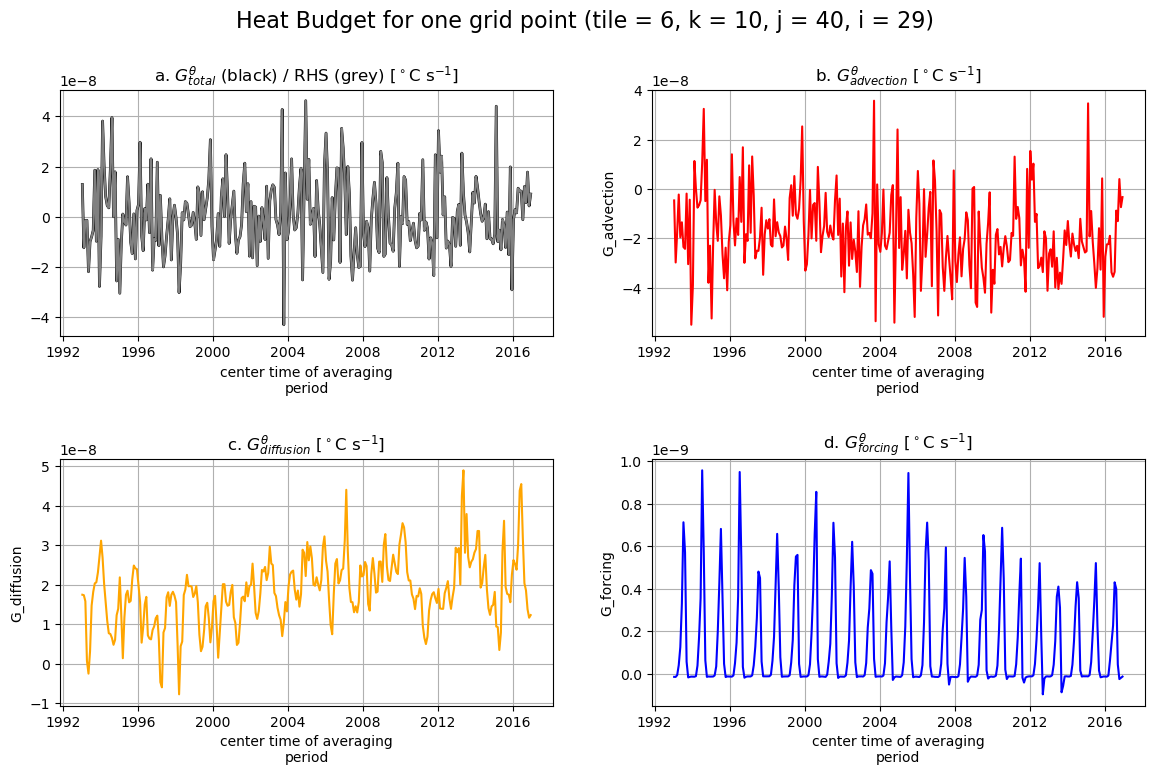

In [89]:
tmp_a = G_total.isel(tile=t,k=k,j=j,i=i).compute()
tmp_b = G_advection.isel(tile=t,k=k,j=j,i=i).compute()
tmp_c = G_diffusion.isel(tile=t,k=k,j=j,i=i).compute()
tmp_d = G_forcing.isel(tile=t,k=k,j=j,i=i).compute()
# tmp_e = rhs.isel(tile=t,k=k,j=j,i=i)

# # save time by not re-computing G_advection, G_diffusion, G_forcing to compute rhs
tmp_e = tmp_b + tmp_c + tmp_d

fig, axs = plt.subplots(2, 2, figsize=(14,8))

plt.sca(axs[0,0])
tmp_a.plot(color='k',lw=2)
tmp_e.plot(color='grey')
axs[0,0].set_title(r'a. $G^\theta_{total}$ (black) / RHS (grey) [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[0,1])
tmp_b.plot(color='r')
axs[0,1].set_title(r'b. $G^\theta_{advection}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,0])
tmp_c.plot(color='orange')
axs[1,0].set_title(r'c. $G^\theta_{diffusion}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()

plt.sca(axs[1,1])
tmp_d.plot(color='b')
axs[1,1].set_title(r'd. $G^\theta_{forcing}$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Heat Budget for one grid point (tile = %i, k = %i, j = %i, i = %i)'%(t,k,j,i), fontsize=16);

Indeed, the heat divergence terms do contribute to $\theta$ variations at a single point. Local heat budget closure is also confirmed at this grid point as we see that the sum of terms on the RHS (grey line) equals the LHS (black line).

For the Arctic grid point, there is a clear seasonal cycles in both $G^\theta_\textrm{total}$, $G^\theta_\textrm{diffusion}$ and $G^\theta_\textrm{forcing}$. The seasonal cycle in $G^\theta_\textrm{forcing}$ seems to be the reverse of $G^\theta_\textrm{total}$ and $G^\theta_\textrm{diffusion}$.

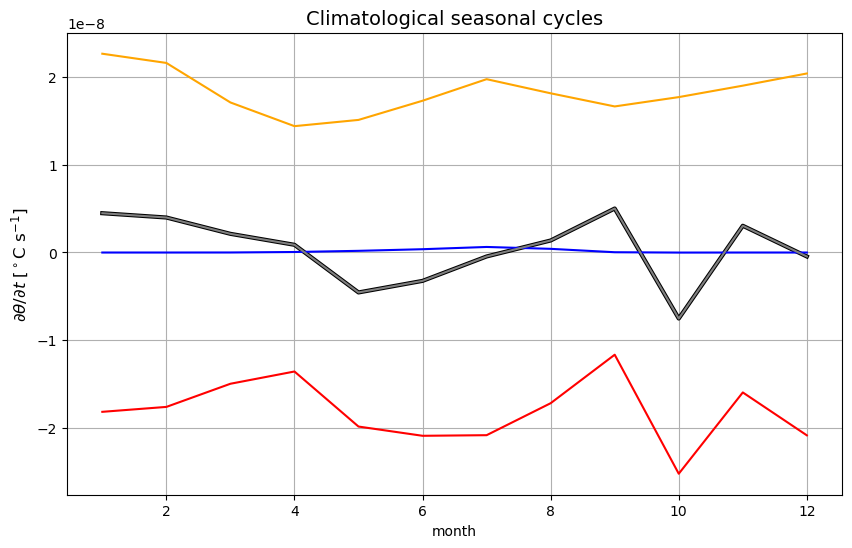

In [90]:
plt.figure(figsize=(10,6));
tmp_a.groupby('time.month').mean('time').plot(color='k',lw=3)
tmp_b.groupby('time.month').mean('time').plot(color='r')
tmp_c.groupby('time.month').mean('time').plot(color='orange')
tmp_d.groupby('time.month').mean('time').plot(color='b')
tmp_e.groupby('time.month').mean('time').plot(color='grey')
plt.ylabel(r'$\partial\theta$/$\partial t$ [$^\circ$C s$^{-1}$]', fontsize=12)
plt.grid()
plt.title('Climatological seasonal cycles', fontsize=14)
plt.show()

The mean seasonal cycle of the total is a balance between advection and diffusion. However, this is likely depth-dependent. How does the balance look across the upper 200 meter at that location?

## Time-mean vertical profiles

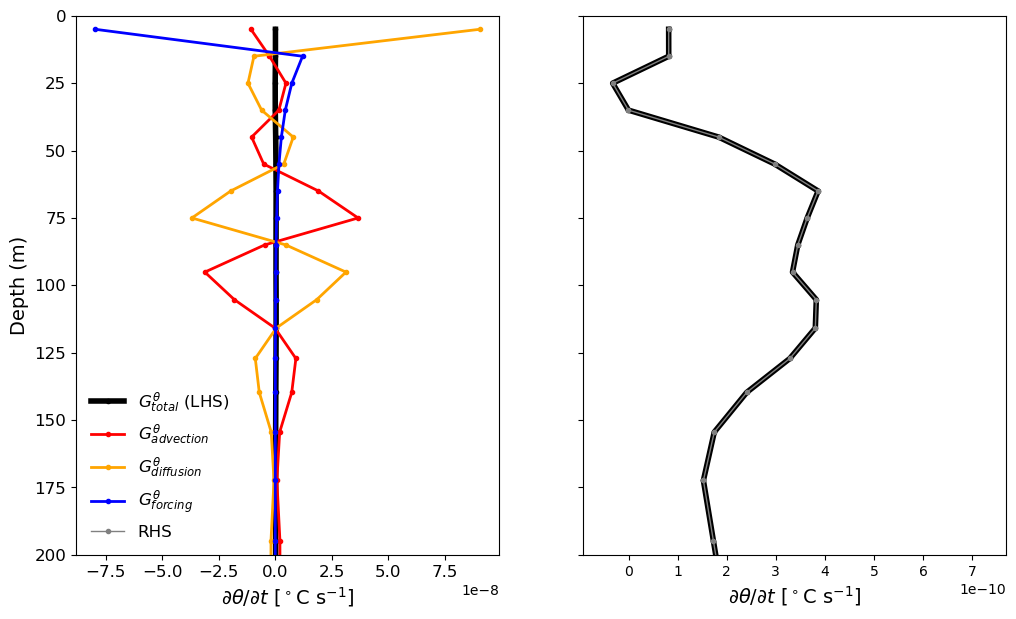

In [91]:
tmp_aa=G_total.isel(tile=t,j=j,i=i).mean('time').compute()
tmp_bb=G_advection.isel(tile=t,j=j,i=i).mean('time').compute()
tmp_cc=G_diffusion.isel(tile=t,j=j,i=i).mean('time').compute()
tmp_dd=G_forcing.isel(tile=t,j=j,i=i).mean('time').compute()
# tmp_ee=rhs.isel(tile=t,j=j,i=i).mean('time').compute()
tmp_ee = tmp_bb + tmp_cc + tmp_dd


fig = plt.subplots(1, 2, sharey=True, figsize=(12,7))

plt.subplot(1, 2, 1)
plt.plot(tmp_aa, -ecco_grid.Z,
         lw=4, color='black', marker='.', label=r'$G^\theta_{total}$ (LHS)')

plt.plot(tmp_bb, -ecco_grid.Z, 
         lw=2, color='red', marker='.', label=r'$G^\theta_{advection}$')

plt.plot(tmp_cc, -ecco_grid.Z, 
         lw=2, color='orange', marker='.', label=r'$G^\theta_{diffusion}$')

plt.plot(tmp_dd, -ecco_grid.Z, 
         lw=2, color='blue', marker='.', label=r'$G^\theta_{forcing}$')
plt.plot(tmp_ee, ecco_grid.Z, lw=1, color='grey', marker='.', label='RHS')
plt.xlabel(r'$\partial\theta$/$\partial t$ [$^\circ$C s$^{-1}$]', fontsize=14)
plt.ylim([200,0])
plt.ylabel('Depth (m)', fontsize=14)
plt.gca().tick_params(axis='both', which='major', labelsize=12)
plt.legend(loc='lower left', frameon=False, fontsize=12)

plt.subplot(1, 2, 2)
plt.plot(tmp_aa, -ecco_grid.Z,
         lw=4, color='black', marker='.', label=r'$G^\theta_{total}$ (LHS)')
plt.plot(tmp_ee, -ecco_grid.Z, lw=1, color='grey', marker='.', label='RHS')
plt.xlabel(r'$\partial\theta$/$\partial t$ [$^\circ$C s$^{-1}$]', fontsize=14)
plt.ylim([200,0])
plt.show()

Balance between surface forcing and diffusion in the top layers. Balance between advection and diffusion at depth.